In [3]:
# ✅ Install dependencies (Colab only) (may take 5 mins approx)
!pip install -q torch torchvision matplotlib

# Semantic Segmentation

### Pretrained For Fun

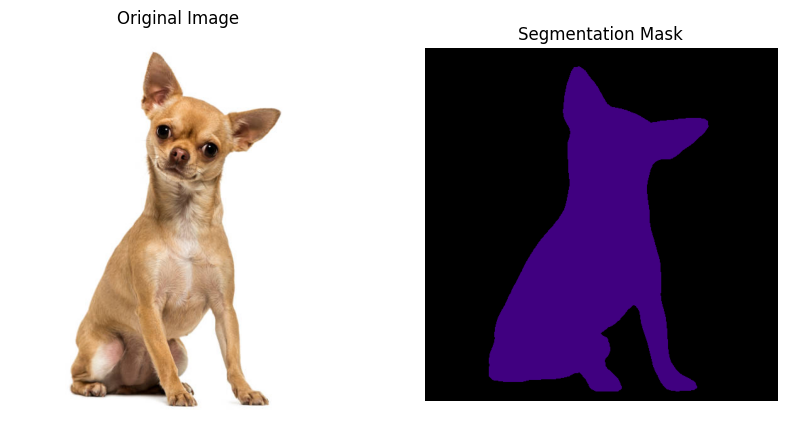

In [5]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a pre-trained DeepLabV3 model
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

# Load and preprocess the image
img_path = "cdog.jpg"
input_image = Image.open(img_path).convert("RGB")

# Preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image).unsqueeze(0)  # add batch dimension

# Inference
with torch.no_grad():
    output = model(input_tensor)['out'][0]  # get output from model
    output_predictions = output.argmax(0)   # get the class with highest probability

# Decode segmentation map
def decode_segmap(segmentation, num_classes=21):
    # Pascal VOC colormap
    label_colors = np.array([
        (0, 0, 0),        # 0=background
        (128, 0, 0),      # 1=aeroplane
        (0, 128, 0),      # 2=bicycle
        (128, 128, 0),    # 3=bird
        (0, 0, 128),      # 4=boat
        (128, 0, 128),    # 5=bottle
        (0, 128, 128),    # 6=bus
        (128, 128, 128),  # 7=car
        (64, 0, 0),       # 8=cat
        (192, 0, 0),      # 9=chair
        (64, 128, 0),     # 10=cow
        (192, 128, 0),    # 11=dining table
        (64, 0, 128),     # 12=dog
        (192, 0, 128),    # 13=horse
        (64, 128, 128),   # 14=motorbike
        (192, 128, 128),  # 15=person
        (0, 64, 0),       # 16=potted plant
        (128, 64, 0),     # 17=sheep
        (0, 192, 0),      # 18=sofa
        (128, 192, 0),    # 19=train
        (0, 64, 128),     # 20=tv/monitor
    ])

    r = np.zeros_like(segmentation, dtype=np.uint8)
    g = np.zeros_like(segmentation, dtype=np.uint8)
    b = np.zeros_like(segmentation, dtype=np.uint8)

    for l in range(num_classes):
        idx = segmentation == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Display original and segmentation mask
segmentation_map = decode_segmap(output_predictions.numpy())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmentation_map)
plt.title("Segmentation Mask")
plt.axis('off')
plt.show()


# Instance Segmentation (was called Object Segmentation)

/opt/anaconda3/envs/ipykernel_py3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/oysterable/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:15<00:00, 11.2MB/s] 


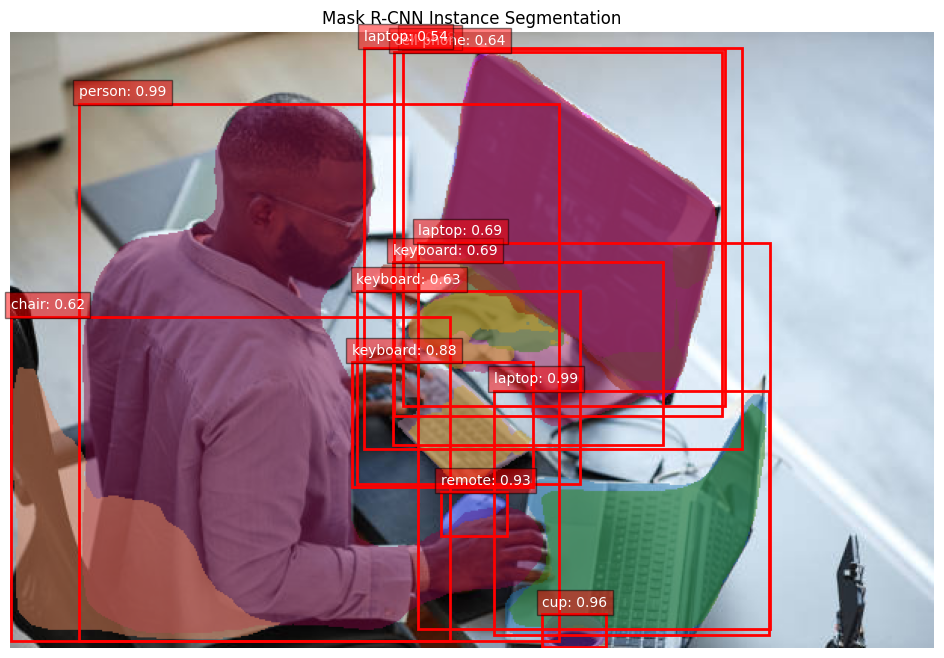

In [6]:
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

# Load a pretrained Mask R-CNN model
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Load and transform image
image_path = "stock1.jpg"
image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.ToTensor()
])
img_tensor = transform(image).unsqueeze(0)

# Predict
with torch.no_grad():
    prediction = model(img_tensor)[0]

# Set a threshold to filter predictions
threshold = 0.5
masks = prediction['masks'] > threshold
boxes = prediction['boxes']
labels = prediction['labels']
scores = prediction['scores']

# COCO classes
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
    'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
    'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop',
    'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
    'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

# Visualize predictions
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(image)

for i in range(len(masks)):
    if scores[i] > threshold:
        # Draw bounding box
        box = boxes[i].cpu().numpy()
        x1, y1, x2, y2 = box.astype(int)
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   fill=False, color='red', linewidth=2))

        # Show label
        label = COCO_INSTANCE_CATEGORY_NAMES[labels[i]]
        ax.text(x1, y1 - 5, f"{label}: {scores[i]:.2f}", color='white',
                bbox=dict(facecolor='red', alpha=0.5))

        # Overlay mask
        mask = masks[i, 0].cpu().numpy()
        rgba_mask = np.zeros((*mask.shape, 4), dtype=np.float32)
        color = np.random.rand(3)
        rgba_mask[..., :3] = color
        rgba_mask[..., 3] = mask * 0.5  # alpha channel
        ax.imshow(rgba_mask)

plt.axis('off')
plt.title("Mask R-CNN Instance Segmentation")
plt.show()


# Custom Semantic Segmentation

By creating a U-Net model inspired by this paper: https://arxiv.org/abs/1505.04597

In [ ]:
# 📚 Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# ⚙️ Device configuration
# If GPU is available, use it; otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 📥 Load the Oxford-IIIT Pet Dataset with segmentation masks
# We use torchvision's dataset utility with transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor()           # Convert PIL images to PyTorch tensors
])


We use the Oxford Pet Dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/

In [ ]:
# Load the dataset with segmentation targets
dataset = datasets.OxfordIIITPet(
    root="./data", split="trainval", target_types="segmentation",
    transform=transform, target_transform=transform, download=True
)

In [ ]:
# wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
# wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

In [ ]:
# 🔀 Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [ ]:
# 📦 DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# 🧠 Implement the U-Net model architecture from scratch

# https://debuggercafe.com/unet-from-scratch-using-pytorch/ 


in_channels=3   # 
num_classes=1   # 1 because mask is a binary image (use 3 for colored)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super(UNet, self).__init__()

        # Reusable convolution block: Conv -> ReLU -> Conv -> ReLU
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        # Downsampling path
        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)  # Reduce spatial resolution by factor of 2

        # Bottleneck
        self.bottleneck = conv_block(512, 1024)

        # Upsampling path
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)  # 1x1 conv to get mask output

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder with skip connections
        d4 = self.up4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))  # Apply sigmoid for binary mask

In [ ]:
# 🏗️ Instantiate model, define loss and optimizer
model = UNet().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for mask prediction
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 🏋️ Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()               # Reset gradients
        outputs = model(images)            # Forward pass
        loss = criterion(outputs, masks)   # Compute loss
        loss.backward()                    # Backpropagation
        optimizer.step()                   # Update weights
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")


In [ ]:
# 🔍 Evaluation on validation set
model.eval()
val_loss = 0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        val_loss += loss.item()
print(f"\nValidation Loss: {val_loss / len(val_loader):.4f}")

In [ ]:
# 📊 Visualize predictions
model.eval()
def visualize_predictions(model, loader, num_images=3):
    images, masks = next(iter(loader))
    images, masks = images[:num_images], masks[:num_images]
    outputs = model(images.to(device)).cpu().detach()
    outputs = (outputs > 0.5).float()  # Threshold for binary mask

    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    for i in range(num_images):
        axes[i, 0].imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(masks[i].squeeze(), cmap="gray")
        axes[i, 1].set_title("True Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(outputs[i].squeeze(), cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# 🔎 Show results
visualize_predictions(model, val_loader)

# Assigments

### Image Classification
- 1. Implement(Reuse) Resnet50 to do prediction for cdog image (Pytorch)
- 2. Custom Train Resnet50 with Fruits dataset to predict the name of the fruit (Hint: Change FC layer)